<a href="https://colab.research.google.com/github/slachitoff/CS-GY-6613-Assignments/blob/main/CS_GS_6613_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


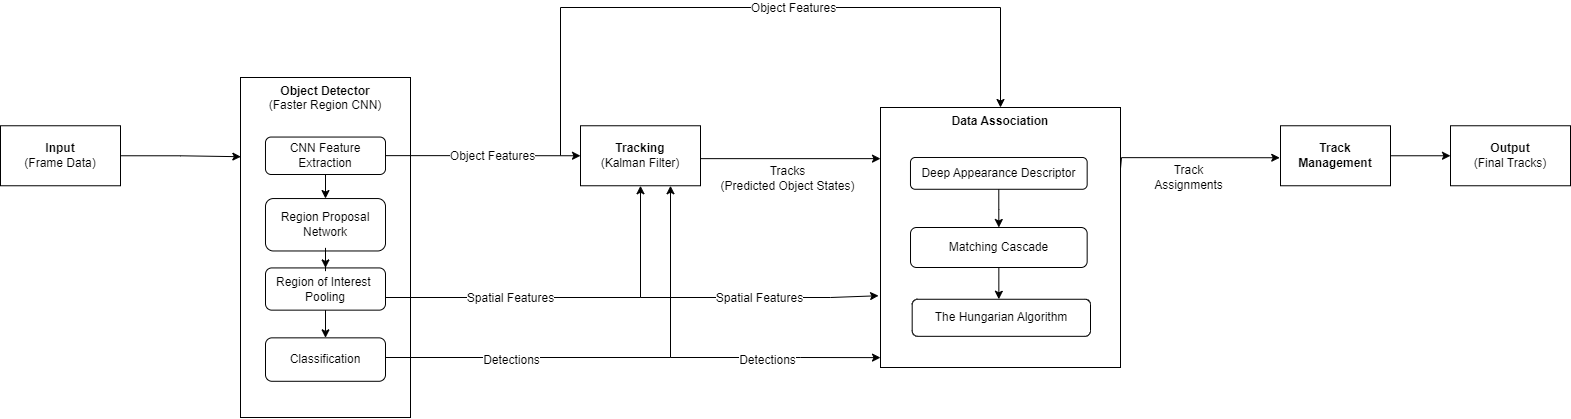

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import Image
Image('/content/drive/MyDrive/Assignment_3_Diagram.png')

# Task 1
Deep-SORT takes sequential data, in this case video frames, as it's initial input. Those images are passed into a Faster Region-based Convolutional Neural Network (FrRCNN) which acts as an object detector. 

The FrRCNN is itself a multi-stage process, beginning with feature extraction. Here, each image is passed through a CNN backbone which generates a high-dimensional vector of features. This vector is then passed onto the next stage of the Object Detection process, the Region Proposal Network (RPN), which uses anchor windows to generate a set of Regions of Interest (RoIs), or areas in the image that are likely to contain objects of significance. This set of proposals is then sent to the RoI Pooling layer, which uses the object feature map generated in the feature extraction stage to interpolate the features of the object proposals into a fixed-size feature map. This fixed-size feature map is then fed into a classification network which outputs detections in the form of class labels, confidence scores, and bounding box locations for each proposal.

In the tracking stage, a Kalman filter uses the object features, spatial features, and detections output from the object detection stage to predict the future state of each target.  These state predictions are used to propagate object identities across frames, as well as maintain object identities in the event of occlusion..  

The state of each object is represented as an eight-dimensional vector $x = [u, v, \gamma, h, \dot{u}, \dot{v}, \dot{\gamma}, \dot{h}]^T$, where $u$ and $v$ are the horizontal and vertical coordinates of the center of the target object, $\gamma$ is the aspect ratio of the bounding box, $h$ is the height of the bounding box, and $\dot{u}, \dot{v}, \dot{\gamma}, \dot{h}$ represent the respective velocities of the horizontal, vertical, aspect ratio, and height dimensions.

A linear constant velocity model $x_t=A_tx_{t-1} + w_t$ is used to predict the state $x$ of each object at frame $t$, where $x_{t-1}$ is the state of the object in the previous frame. Here, $A_t$ is a $8 \times 8$ state transition matrix which describes how the state of the object has changed from frame $t-1$ to frame $t$.

When the true location of the object is determined in later frames, it is input back into the Kalman filter as an observation. This observation is expressed as $z_t = C_t x_t+v_t$, where $C_t$ is a $4 \times 8$ matrix that maps the state $x_t$ to a measurement space of size $4$ (for the $u$, $v$, $\gamma$, and $h$ coordinates), and $v_t$ is the measurement noise representing the degree of uncertainty regarding the measurement $z_t$.

The Kalman Gain at time $t$ can be expressed as $K_t = \hat{\Sigma_t} C_t^T (C_t \hat{\Sigma_t} C_t^T + Q_t)^{-1}$, where $\hat{\Sigma_t}$ is the predicted state covariance matrix, $C_t$ is the measurement matrix, and $Q_t$ is the measurement noise covariance matrix.

The Kalman Gain and the measurement are used to derive $x_t = \hat{x}_t + K_t(z_t-C_t\hat{x}_t)$, where $\hat{x}_t$ is the predicted state estimate, and $C_t\hat{x}_t$ is the predicted measurement. The state covariance matrix is also updated, giving $\Sigma_t = (I - K_t C_t)\hat{\Sigma_t}$.

These measurements are used to decrease the probability distribution variance, thereby improving the accuracy of subsequent predictions. At each frame $t$, the Kalman filter outputs a set of predictions regarding the object states, $\hat{x}_t$, along with the associated state covariance matrices $\Sigma_t$.

The object features, spatial features, and detections in the object detection stage, as well as the predicted object states output by the the Kalman filter, are used as input into the data association stage of the process. 

The probability distributions output by the Kalman filter are compared to the observed positions of the detected objects in each frame forming what is called the Mahalanobis distance.

As part of the data association stage, the deep appearance descriptor is a CNN which is trained on a large-scale person re-identification dataset. It takes as input a cropped image of an objects outputs a high-dimensional feature vector that represents the appearance of the object in the image. The cosine distance between vectors can then be computed, resulting in a score representing the similarity between the appearance of objects between frames.

The resulting cosine distance score from the deep appearance descriptor, and the Mahalanobis distance can be linearly combined to form a scalar value that can be used by the Hungarian algorithm to assign detections to their identities.

The Hungarian algorithm is a global optimization algorithm which takes as its input a cost matrix consisting of the intersection-over-union (IoU) distances between the bounding box locations output by the object detection classifier network, and the predicted states produced by the Kalman filter. Given $n$ targets, we have $n$ predicted states which must be matched to $n$ detections.

A brute force approach to this linear assignment problem is of $\theta(n!)$ time complexity. In comparison, the Hungarian algorithm is able to solve this same problem in $\theta(n^3)$, thereby establishing an initial correspondence between the tracks and the detections more efficiently than otherwise possible.

Cascade matching is an extension of the IoU matching algorithm mentioned above. In an effort to reduce the time complexity of the Hungarian algorithm, cascade matching attempts to match the most recent detections to the most recent identifications, and older detections with older identifications. 











# Task 3
In the original Simple Online and Realtime Tracking paper, the authors explicitly state that, "...incorporating complexity in the form of object re-identification adds significant overhead..." which could potentially limit the abilit for SORT to be used in real-time applications. Later in the paper, they reiterate this shortcoming, stating that, "...object re-identification is beyond the scope of
this work..." That being said, the follow-up, Simple Online and Realtime Tracking With a Deep Association Metric, attempts to address this issue by introducing the Deep Appearance Descriptor which is explicitly trained on a re-identification dataset, in an effort to reduce the likelihood of track fragmentation or identity switches. Even so, there are limitations, and given that in a game of soccer, players are wearing nearly identical outfits, much of the discriminative power of their appearance have been greatly reduced. The smaller details such as facial features are far less apparent, and thus is is completely understandable as to why the Deep-SORT algorithm would struggle to identify players.

In [ ]:
!git clone https://github.com/nwojke/deep_sort.git
pip install deep_sort

SyntaxError: ignored

In [ ]:
!mkdir ./yolov5_deepsort
!git clone https://github.com/ultralytics/yolov5.git

%cd ./yolov5
!pip install -r requirements.txt
 
import argparse
import os
import sys
from pathlib import Path
 
import torch
import torch.backends.cudnn as cudnn
 
FILE = Path('/content/yolov5/detect.py').resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory.
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # Add ROOT to PATH.
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # Relative.
 
# DeepSORT -> Importing DeepSORT.
from deep_sort.application_util import preprocessing
from deep_sort.deep_sort import nn_matching
from deep_sort.deep_sort.detection import Detection
from deep_sort.deep_sort.tracker import Tracker
from deep_sort.tools import generate_detections as gdet
 
 
from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                          increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
 
 
@torch.no_grad()
def run(
        weights=ROOT / 'yolov5s.pt',  # model.pt path(s)
        source=ROOT / 'data/images',  # file/dir/URL/glob, 0 for webcam
        data=ROOT / 'data/coco128.yaml',  # dataset.yaml path.
        imgsz=(640, 640),  # Inference size (height, width).
        conf_thres=0.25,  # Confidence threshold.
        iou_thres=0.45,  # NMS IOU threshold.
        max_det=1000,  # Maximum detections per image.
        device='',  # Cuda device, i.e. 0 or 0,1,2,3 or cpu.
        view_img=False,  # Show results.
        save_txt=False,  # Save results to *.txt.
        save_conf=False,  # Save confidences in --save-txt labels.
        save_crop=False,  # Save cropped prediction boxes.
        nosave=False,  # Do not save images/videos.
        classes=None,  # Filter by class: --class 0, or --class 0 2 3.
        agnostic_nms=False,  # Class-agnostic NMS.
        augment=False,  # Augmented inference.
        visualize=False,  # Visualize features.
        update=False,  # Update all models.
        project=ROOT / 'runs/detect',  # Save results to project/name.
        name='exp',  # Save results to project/name.
        exist_ok=False,  # Existing project/name ok, do not increment.
        line_thickness=3,  # Bounding box thickness (pixels).
        hide_labels=False,  # Hide labels.
        hide_conf=False,  # Hide confidences.
        half=False,  # Use FP16 half-precision inference.
        dnn=False,  # Use OpenCV DNN for ONNX inference.
):
    source = str(source)
    save_img = not nosave and not source.endswith('.txt')  # Save inference images.
    is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
    is_url = source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))
    webcam = source.isnumeric() or source.endswith('.txt') or (is_url and not is_file)
    if is_url and is_file:
        source = check_file(source)  # Download.
 
    # DeepSORT -> Initializing tracker.
    max_cosine_distance = 0.4
    nn_budget = None
    model_filename = './model_data/mars-small128.pb'
    encoder = gdet.create_box_encoder(model_filename, batch_size=1)
    metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
    tracker = Tracker(metric)
    
    # Directories.
    if not os.path.isdir('./runs/'):
      os.mkdir('./runs/')
    save_dir = os.path.join(os.getcwd(), "runs")
    print(save_dir)
    '''save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir'''
 
    # Load model.
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)  # Check image size.
 
    # Dataloader.
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # Set True to speed up constant image size inference.
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt)
        bs = len(dataset)  # batch_size.
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
        bs = 1  # batch_size.
    vid_path, vid_writer = [None] * bs, [None] * bs
 
    # Run inference.
    model.warmup(imgsz=(1 if pt else bs, 3, *imgsz))  # Warmup.
    dt, seen = [0.0, 0.0, 0.0], 0
    frame_idx=0
    for path, im, im0s, vid_cap, s in dataset:
        t1 =  time_sync()
        im = torch.from_numpy(im).to(device)
        im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32.        im /= 255  # 0 - 255 to 0.0 - 1.0
        if len(im.shape) == 3:
            im = im[None]  # Expand for batch dim.
        t2 = time_sync()
        dt[0] += t2 - t1
 
        # Inference.
        visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
        pred = model(im, augment=augment, visualize=visualize)
        t3 = time_sync()
        dt[1] += t3 - t2
 
        # NMS.
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        dt[2] += time_sync() - t3
 
        # Second-stage classifier (optional).
        # pred = utils.general.apply_classifier(pred, classifier_model, im, im0s)
 
        frame_idx=frame_idx+1
        # Process predictions.
        for i, det in enumerate(pred):  # Per image.
            seen += 1
            if webcam:  # batch_size >= 1
                p, im0, frame = path[i], im0s[i].copy(), dataset.count
                s += f'{i}: '
            else:
                p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)
 
            p = Path(p)  # To Path.
            print("stem", p.stem)
            print("dir", save_dir)
            save_path = os.path.join(save_dir, p.name)  # im.jpg
            txt_path = os.path.join(save_dir , p.stem) # im.txt
            s += '%gx%g ' % im.shape[2:]  # Print string.
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # Normalization gain whwh.
            imc = im0.copy() if save_crop else im0  # For save_crop.
            annotator = Annotator(im0, line_width=line_thickness, example=str(names))
 
            if len(det):
                # Rescale boxes from img_size to im0 size.
                det[:, :4] = scale_coords(im.shape[2:], det[:, :4], im0.shape).round()
 
                # Print results.
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # Detections per class.
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # Add to string.
 
                # DeepSORT -> Extracting Bounding boxes and its confidence scores.
                bboxes = []
                scores = []
                for *boxes, conf, cls in det:
                  bbox_left = min([boxes[0].item(), boxes[2].item()])
                  bbox_top = min([boxes[1].item(), boxes[3].item()])
                  bbox_w = abs(boxes[0].item() - boxes[2].item())
                  bbox_h = abs(boxes[1].item() - boxes[3].item())
                  box = [bbox_left, bbox_top, bbox_w, bbox_h]
                  bboxes.append(box)
                  scores.append(conf.item())
                
                # DeepSORT -> Getting appearance features of the object.
                features = encoder(im0, bboxes)
                # DeepSORT -> Storing all the required info in a list.
                detections = [Detection(bbox, score, feature) for bbox, score, feature in zip(bboxes, scores, features)]
 
                # DeepSORT -> Predicting Tracks.
                tracker.predict()
                tracker.update(detections)
                #track_time = time.time() - prev_time
 
                # DeepSORT -> Plotting the tracks.
                for track in tracker.tracks:
                  if not track.is_confirmed() or track.time_since_update > 1:
                      continue
 
                  # DeepSORT -> Changing track bbox to top left, bottom right coordinates.
                  bbox = list(track.to_tlbr())
 
                  # DeepSORT -> Writing Track bounding box and ID on the frame using OpenCV.
                  txt = 'id:' + str(track.track_id)
                  (label_width,label_height), baseline = cv2.getTextSize(txt , cv2.FONT_HERSHEY_SIMPLEX,1,1)
                  top_left = tuple(map(int,[int(bbox[0]),int(bbox[1])-(label_height+baseline)]))
                  top_right = tuple(map(int,[int(bbox[0])+label_width,int(bbox[1])]))
                  org = tuple(map(int,[int(bbox[0]),int(bbox[1])-baseline]))
 
                  cv2.rectangle(im0, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255,0,0), 1)
                  cv2.rectangle(im0, top_left, top_right, (255,0,0), -1)
                  cv2.putText(im0, txt, org, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1)
 
                  # DeepSORT -> Saving Track predictions into a text file.
                  save_format = '{frame},{id},{x1},{y1},{w},{h},{x},{y},{z}\n'
                  print("txt: ", txt_path, '.txt')
                  with open(txt_path + '.txt', 'a') as f:
                    line = save_format.format(frame=frame_idx, id=track.track_id, x1=int(bbox[0]), y1=int(bbox[1]), w=int(bbox[2]- bbox[0]), h=int(bbox[3]-bbox[1]), x = -1, y = -1, z = -1)
                    f.write(line)
 
            # Stream results.
            im0 = annotator.result()
 
            # Save results (image with detections and tracks).
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path[i] != save_path:  # New video.
                        vid_path[i] = save_path
                        if isinstance(vid_writer[i], cv2.VideoWriter):
                            vid_writer[i].release()  # Release previous video writer.
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # Stream.
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                        save_path = str(Path(save_path).with_suffix('.mp4'))  # Force *.mp4 suffix on results videos.
                        vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer[i].write(im0)
 
        # Print time (inference-only).
        LOGGER.info(f'{s}Done. ({t3 - t2:.3f}s)')
 
    # Print results.
    t = tuple(x / seen * 1E3 for x in dt)  # Speeds per image.
    LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {(1, 3, *imgsz)}' % t)
    if update:
        strip_optimizer(weights)  # Update model (to fix SourceChangeWarning).
 
 
def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default=ROOT / 'yolov5s.pt', help='model path(s)')
    parser.add_argument('--source', type=str, default=ROOT / 'data/images', help='file/dir/URL/glob, 0 for webcam')
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128.yaml', help='(optional) dataset.yaml path')
    parser.add_argument('--imgsz', '--img', '--img-size', nargs='+', type=int, default=[640], help='inference size h,w')
    parser.add_argument('--conf-thres', type=float, default=0.25, help='confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.45, help='NMS IoU threshold')
    parser.add_argument('--max-det', type=int, default=1000, help='maximum detections per image')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='show results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-crop', action='store_true', help='save cropped prediction boxes')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --classes 0, or --classes 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--visualize', action='store_true', help='visualize features')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default=ROOT / 'runs/detect', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--line-thickness', default=3, type=int, help='bounding box thickness (pixels)')
    parser.add_argument('--hide-labels', default=False, action='store_true', help='hide labels')
    parser.add_argument('--hide-conf', default=False, action='store_true', help='hide confidences')
    parser.add_argument('--half', action='store_true', help='use FP16 half-precision inference')
    parser.add_argument('--dnn', action='store_true', help='use OpenCV DNN for ONNX inference')
    opt = parser.parse_args()
    opt.imgsz *= 2 if len(opt.imgsz) == 1 else 1  # Expand.
    print_args(vars(opt))
    return opt
 
def main(opt):
    check_requirements(exclude=('tensorboard', 'thop'))
    run(**vars(opt))
 
if __name__ == "__main__":
    opt = parse_opt()
    main(opt)